# Traffic sign classification using a convolutional neural network in MXNet

TODO: Add link to blog article when it's ready.
1. In this notebook we are going to classify German traffic signs using a convolutional neural network
2. We will learn about implementing convolution using MXNet.
3. The notebook assumes that you have a broad understanding of convolutional neural networks.

In [1]:
#some imports along with mxnet
%matplotlib inline
import mxnet as mx
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [7]:
# Load pickled data
# we already have all the data pickled to file. This helps easy loading of train and validation set
import pickle

# TODO: The train and validation data should be stored inside the folder traffic-data

training_file = "traffic-data/train.p"
validation_file =  "traffic-data/valid.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

We are going to print few statistics to get a sense of what our data looks like. Labelling German traffic signs is a multi-class classification problem. There are, we'll see, 43 different classes of traffic sign in the dataset.

### Statistics about the data

In [19]:

# Number of training examples
n_train = len(X_train)

#Number of testing examples.
n_test = len(X_valid)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))



print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(y_train.shape)

Number of training examples = 34799
Number of testing examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43
(34799,)


In [9]:
#Record the image size, number of channels (RGB) and classes
img_size = X_train[0].shape[0]
num_channels = X_train[0].shape[2]
num_classes = n_classes


The actual names of the classes are given in separate csv file. We need to load the csv file to map label id's to the natural language category names.


In [10]:
# The actual name of the classes are given in separate file. Here we load the csv file which allows mapping from classes/labels to 
# file name
import csv
def read_csv_and_parse():
    traffic_labels_dict ={}
    with open('signnames.csv') as f:
        reader = csv.reader(f)
        count = -1;
        for row in reader:
            count = count + 1
            if(count == 0):
                continue
            label_index = int(row[0])
            traffic_labels_dict[label_index] = row[1]
    return traffic_labels_dict
traffic_labels_dict = read_csv_and_parse()
print(traffic_labels_dict)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

### Next, we will visualise the data and see the corresponding image and traffic sign labels

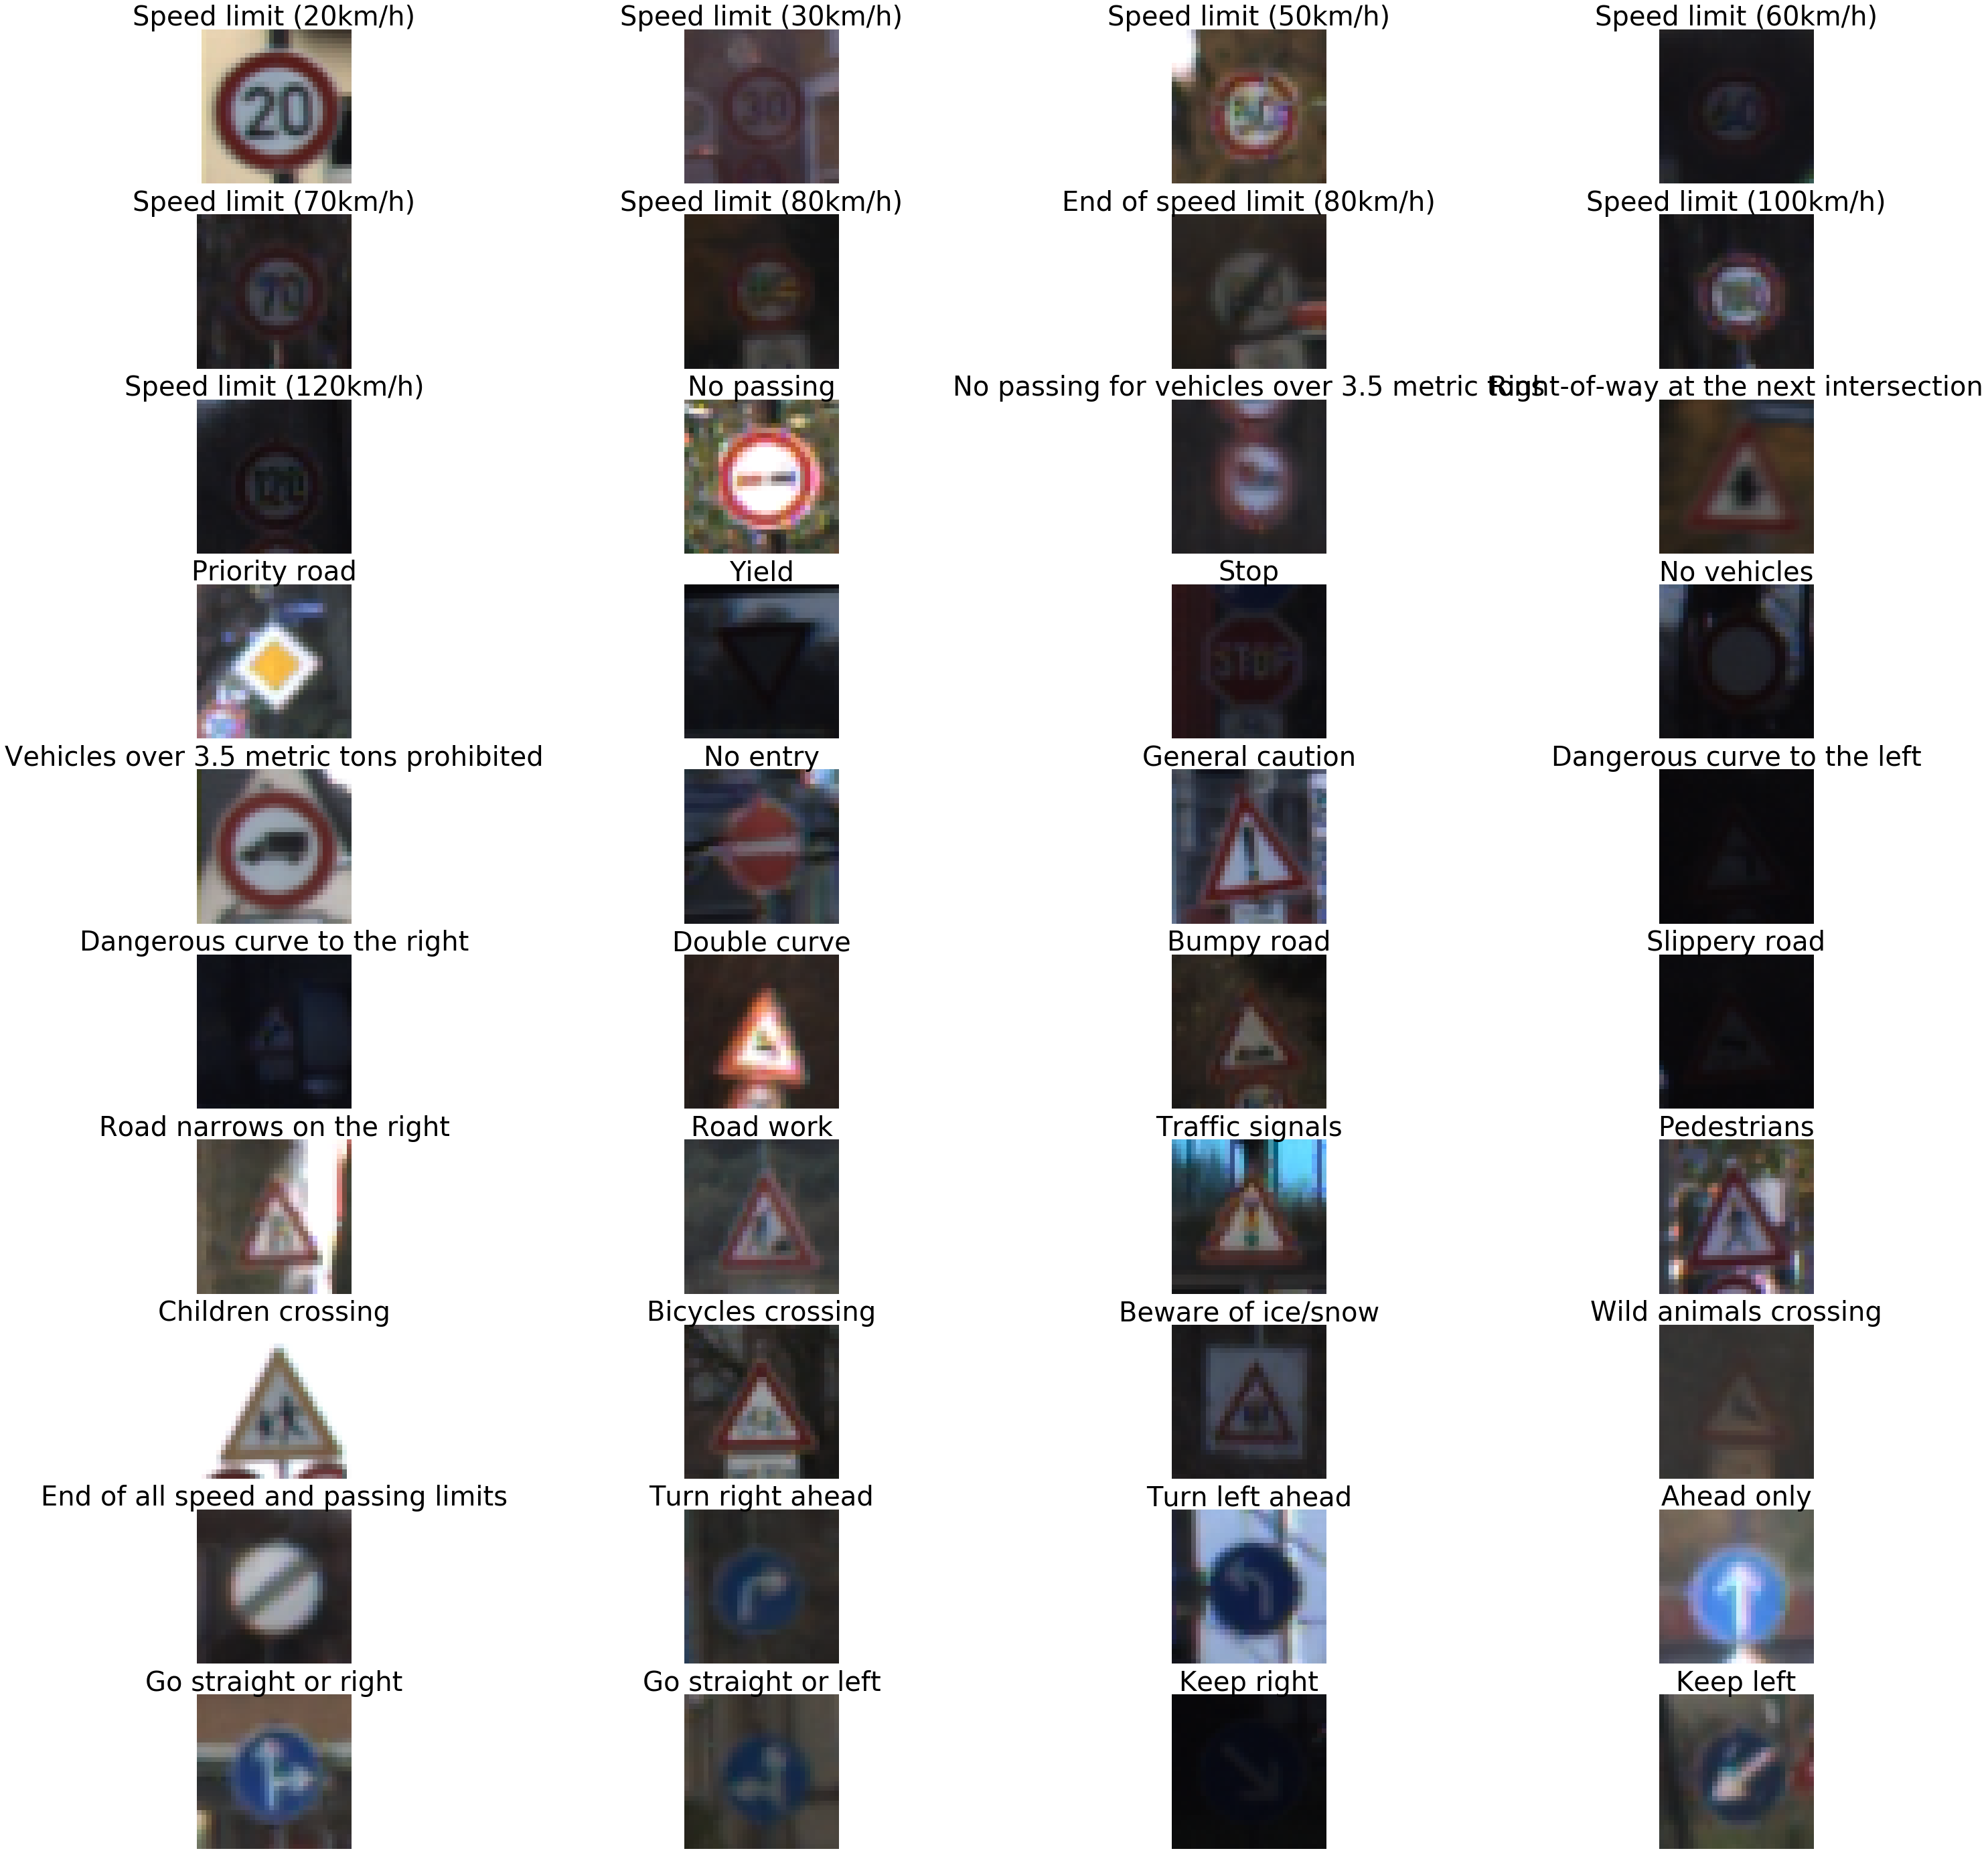

In [11]:
# Data exploration visualization
# This gives better understanding of the data

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
# Visualizations will be shown in the notebook.
%matplotlib inline

#This functions selects one image per class to plot
def get_images_to_plot(images, labels):
    selected_image = []
    idx = []
    for i in range(n_classes):
        selected = np.where(labels == i)[0][0]
        selected_image.append(images[selected])
        idx.append(selected)
    return selected_image,idx
 
# function to plot the images in a grid    
def plot_images(selected_image,y_val,row=5,col=10,idx = None):     
    count =0;
    f, axarr = plt.subplots(row, col,figsize=(50, 50))
   
    for i in range(row): 
         for j in range(col):
                if(count < len(selected_image)):
                    axarr[i,j].imshow(selected_image[count])
                    if(idx != None):
                        axarr[i,j].set_title(traffic_labels_dict[y_val[idx[count]]], fontsize=40)
                axarr[i,j].axis('off')
                count = count + 1
        
            

selected_image,idx = get_images_to_plot(X_train,y_train)
plot_images(selected_image,row=10,col=4,idx=idx,y_val=y_train)

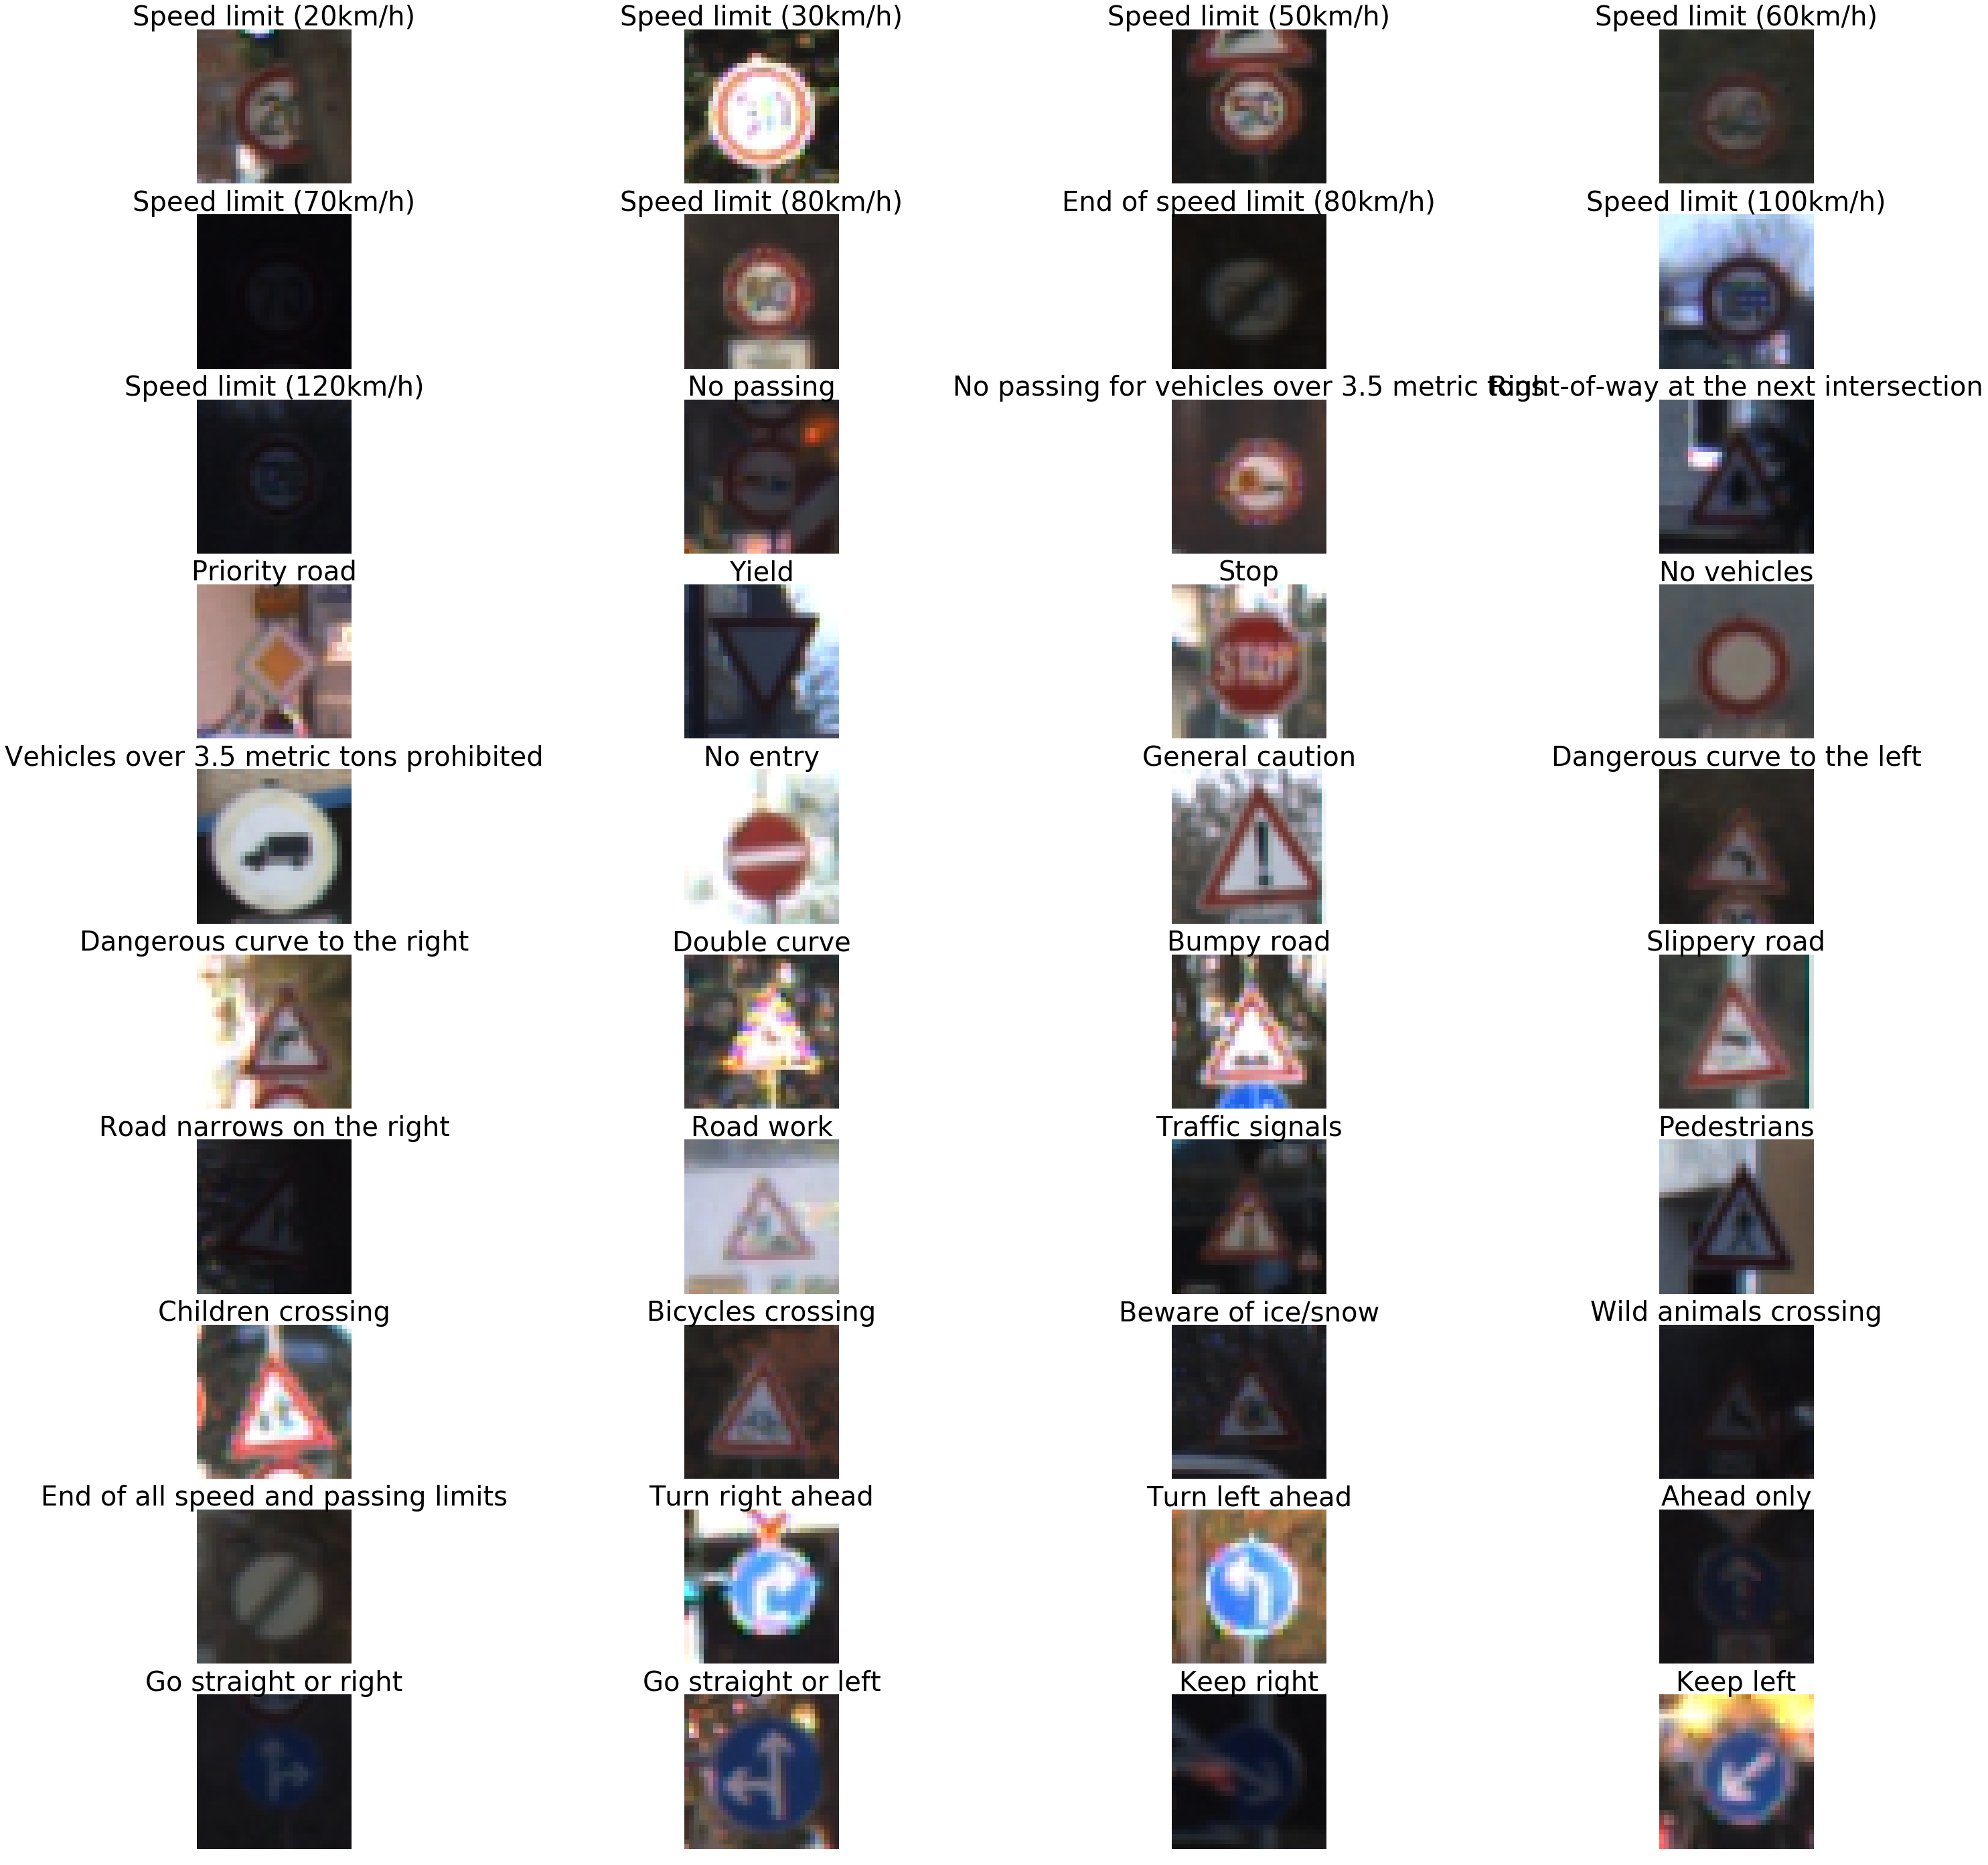

In [15]:
selected_image,idx = get_images_to_plot(X_valid,y_valid)
plot_images(selected_image,row=10,col=4,idx=idx,y_val=y_valid)

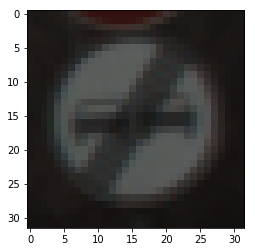

In [16]:
plt.imshow(X_train[28])

(34799, 3, 32, 32)


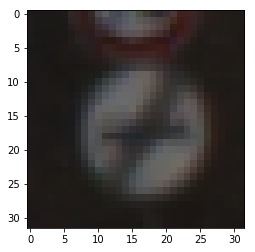

In [17]:
#change the image dimensioning from 32 X 32 X 3 to 3 X 32 X 32 for train

X_train_reshape = np.transpose(X_train, (0, 3, 1, 2))
plt.imshow(X_train_reshape[0].transpose((1,2,0)))
print(X_train_reshape.shape)

(4410, 3, 32, 32)


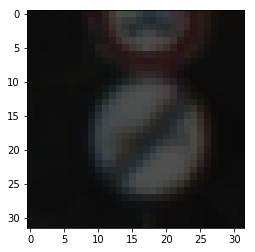

In [18]:
#change the image dimensioning from 32 X 32 X 3 to 3 X 32 X 32 for validation
X_valid_reshape = np.transpose(X_valid, (0, 3, 1, 2))
plt.imshow(X_valid_reshape[1].transpose((1,2,0)))
print(X_valid_reshape.shape)

### Building the deepnet

Now, enough of preparing our dataset. Let's actually code the neural network up. You'll note that there are some commented-out lines; I've left these in as artifacts from the development process—building a successful deep learning model is all about iteration and experimentation to find what works best. 
The neural code is actually small and simple, thanks to MXNet symbol API:

In [37]:

data = mx.symbol.Variable('data')
conv1 = mx.sym.Convolution(data=data, pad=(1,1), kernel=(3,3), num_filter=24, name="conv1")
relu1 = mx.sym.Activation(data=conv1, act_type="relu", name= "relu1")
pool1 = mx.sym.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool1")
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(3,3), num_filter=48, name="conv2", pad=(1,1))
relu2 = mx.sym.Activation(data=conv2, act_type="relu", name="relu2")
pool2 = mx.sym.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool2")

conv3 = mx.sym.Convolution(data=pool2, kernel=(5,5), num_filter=64, name="conv3")
relu3 = mx.sym.Activation(data=conv3, act_type="relu", name="relu3")
pool3 = mx.sym.Pooling(data=relu3, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool3")

#conv4 = mx.sym.Convolution(data=conv3, kernel=(5,5), num_filter=64, name="conv3")
#relu4 = mx.sym.Activation(data=conv4, act_type="relu", name="relu3")
#pool4 = mx.sym.Pooling(data=relu4, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool3")

# first fullc layer
flatten = mx.sym.Flatten(data=pool3)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500, name="fc1")
relu3 = mx.sym.Activation(data=fc1, act_type="relu" , name="relu3")
# second fullc
fc2 = mx.sym.FullyConnected(data=relu3, num_hidden=43,name="final_fc")
# softmax loss
mynet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')


In [38]:
mynet.list_arguments()

['data',
 'conv1_weight',
 'conv1_bias',
 'conv2_weight',
 'conv2_bias',
 'conv3_weight',
 'conv3_bias',
 'fc1_weight',
 'fc1_bias',
 'final_fc_weight',
 'final_fc_bias',
 'softmax_label']

In [39]:
batch_size = 64
X_train_set_as_float = X_train_reshape.astype('float32')
#Noramilsing the image pixel to value between 0 to 1.0
X_train_set_norm = X_train_set_as_float[:] / 255.0;

#Noramilsing the image pixel to value between 0 to 1.0
X_validation_set_as_float = X_valid_reshape.astype('float32')
X_validation_set_norm = X_validation_set_as_float[:] / 255.0 ;


train_iter =mx.io.NDArrayIter(X_train_set_as_float, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_validation_set_as_float, y_valid, batch_size,shuffle=True)


print("train set : ", X_train_set_norm.shape)
print("validation set : ", X_validation_set_norm.shape)


print("y train set : ", y_train.shape)
print("y validation set :", y_valid.shape)


train set :  (34799, 3, 32, 32)
validation set :  (4410, 3, 32, 32)
y train set :  (34799,)
y validation set : (4410,)


### Training the deepnet

We will use adam optimizer to optimize the weights of our deep neural network.

In [40]:
#Create Adam optimiser
adam = mx.optimizer.create('adam')

#Checkpointing (saving the model). Make sure there is folder named models exist
model_prefix = 'models/chkpt'
checkpoint = mx.callback.do_checkpoint(model_prefix)
                                       
#Loading the module API. Previously mxnet used feedforward (deprecated)                                       
model =  mx.mod.Module(
    context = mx.gpu(0),     # use GPU 0 for training; if you don't have a gpu use mx.cpu()
    symbol = mynet,
    data_names=['data']
   )
                                       
#actually fit the model for 10 epochs. Can take 5 minutes                                      
model.fit(
    train_iter,
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 64),
    num_epoch = 10, 
    eval_metric='acc',
    optimizer = adam,
    epoch_end_callback=checkpoint
)

/home/sookinoby/miniconda2/envs/mxnet/lib/python3.5/site-packages/mxnet/module/base_module.py:451: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  optimizer_params=optimizer_params)
INFO:root:Epoch[0] Batch [64]	Speed: 8265.38 samples/sec	Train-accuracy=0.058894
INFO:root:Epoch[0] Batch [128]	Speed: 8232.52 samples/sec	Train-accuracy=0.059082
INFO:root:Epoch[0] Batch [192]	Speed: 8279.29 samples/sec	Train-accuracy=0.059082
INFO:root:Epoch[0] Batch [256]	Speed: 8260.43 samples/sec	Train-accuracy=0.113037
INFO:root:Epoch[0] Batch [320]	Speed: 8230.02 samples/sec	Train-accuracy=0.358154
INFO:root:Epoch[0] Batch [384]	Speed: 8224.93 samples/sec	Train-accuracy=0.500244
INFO:root:Epoch[0] Batch [448]	Speed: 8227.99 samples/sec	Train-accuracy=0.632080
INFO:root:Epoch[0] Batch [512]	Speed: 8265.45 samples/sec	Train-accuracy=0.709961
INFO:root:Epoch[0] Train-accuracy=0.721774
INFO:roo

In [42]:
acc = mx.metric.Accuracy()
model.score(val_iter,acc)
print(acc)


EvalMetric: {'accuracy': 0.93229166666666663}


In [43]:
# Load the model from the checkpoint , we are loading the 10 epoch
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, 10)

# Assign the loaded parameters to the module
mod = mx.mod.Module(symbol=sym, context=mx.cpu())
mod.bind(for_training=False, data_shapes=[('data', (1,3,32,32))])
mod.set_params(arg_params, aux_params)

/home/sookinoby/miniconda2/envs/mxnet/lib/python3.5/site-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


class=Stop
class=Speed limit (30km/h)
class=Speed limit (20km/h)
class=Speed limit (70km/h)
class=Bicycles crossing


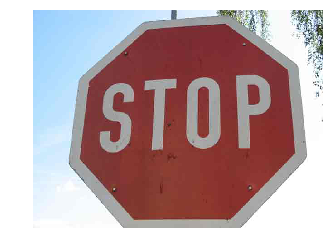

In [44]:
#Prediction for random traffic sign from internet
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

#load the image , resizes it to 32*32 and converts it to 1*3*32*32 
def get_image(url, show=False):
    # download and show the image
    img =cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (32, 32))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) #swaps axis to make it 3*32*32
    #plt.imshow(img.transpose(1,2,0))
    #plt.axis('off')
    img = img[np.newaxis, :] # Add a extra axis to the image so it becomes 1*3*32*32
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    prob = np.argsort(prob)[::-1]
    for i in prob[0:5]:
        print('class=%s' %(traffic_labels_dict[i]))

predict('traffic-data/Stop.jpg',)
